In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
from subprocess import Popen, PIPE

process = Popen(['nvidia-smi'], stdout=PIPE)
(output, err) = process.communicate()
exit_code = process.wait()
print(output.decode('utf8'))

Thu Dec  2 18:50:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   53C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# When working with lots of real-world image data, corrupted images are a common occurence.
# Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

import os

num_skipped = 0
for folder_name in ("cat", "dog"):
    folder_path = os.path.join("pet-images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        except Exception as ex:
            print(ex)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
# Generate a Dataset
image_size = (180, 180)
batch_size = 18
# my poor laptop GPU won't support any size larger...

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "pet-images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "pet-images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


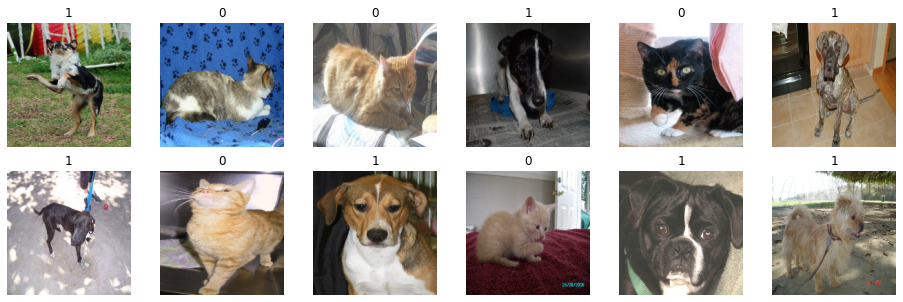

In [6]:
# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by
# applying random yet realistic transformations to the training images, such as random horizontal flipping or 
# small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

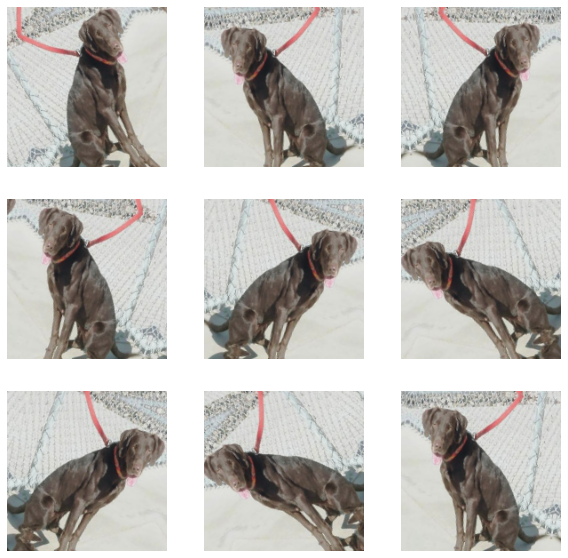

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

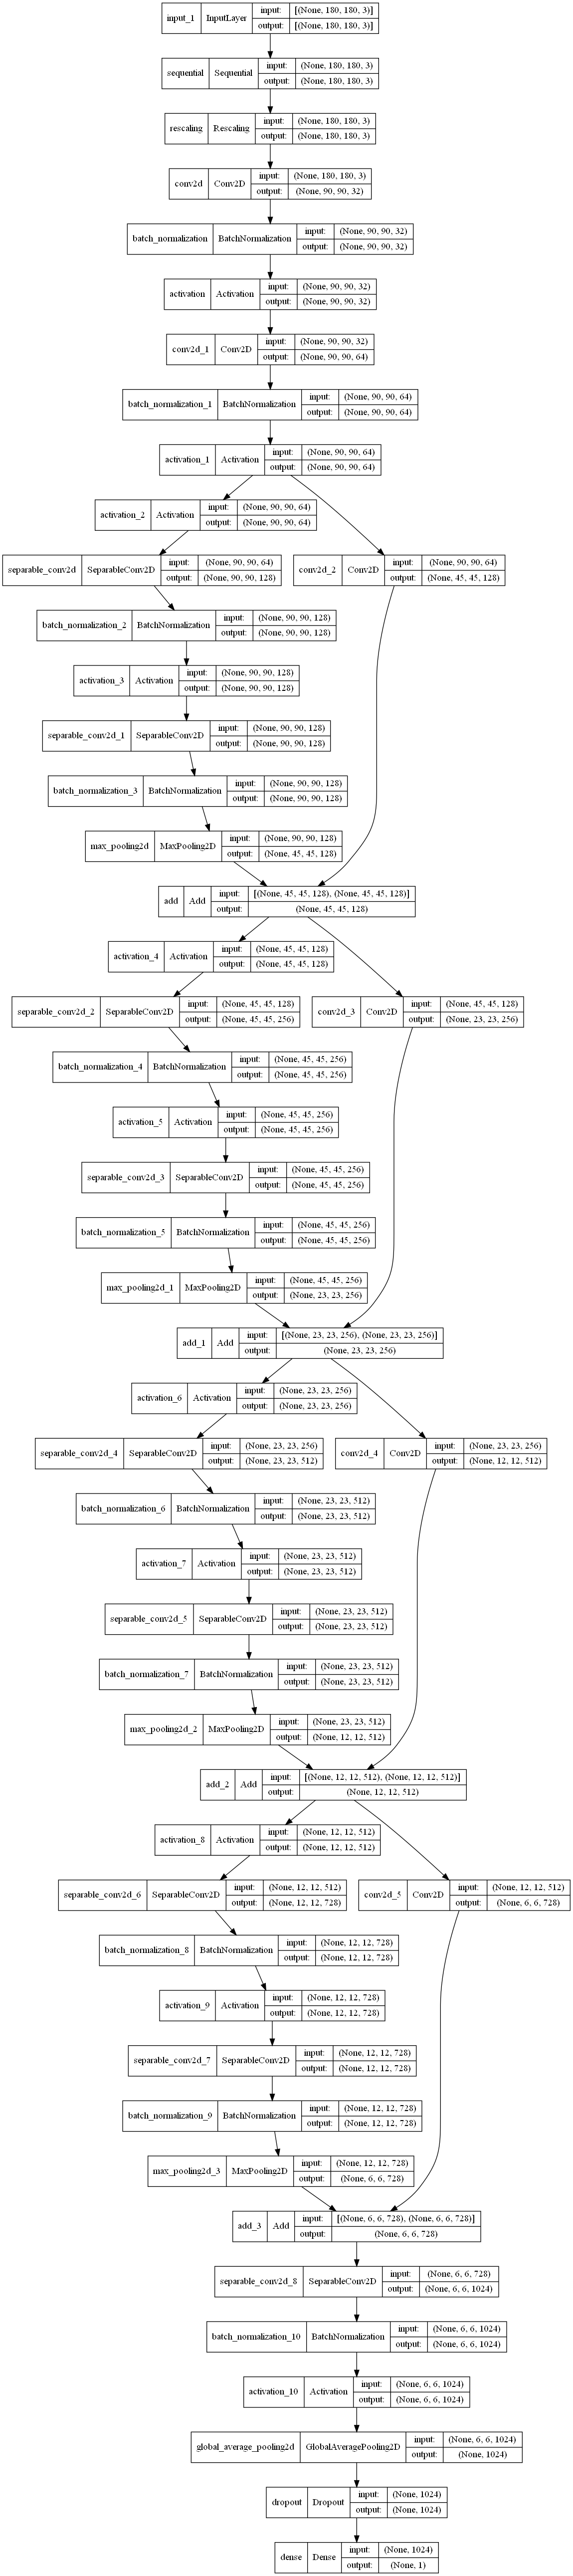

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [11]:
epochs = 50

callbacks = [
  #  keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
1041/1041 [==============================] - 667s 629ms/step - loss: 0.6323 - accuracy: 0.6578 - val_loss: 0.5709 - val_accuracy: 0.7114
Epoch 2/50
1041/1041 [==============================] - 668s 641ms/step - loss: 0.4852 - accuracy: 0.7687 - val_loss: 0.6359 - val_accuracy: 0.7324
Epoch 3/50
1041/1041 [==============================] - 667s 640ms/step - loss: 0.4009 - accuracy: 0.8225 - val_loss: 0.3979 - val_accuracy: 0.8236
Epoch 4/50
1041/1041 [==============================] - 663s 637ms/step - loss: 0.3377 - accuracy: 0.8558 - val_loss: 0.4456 - val_accuracy: 0.8031
Epoch 5/50
1041/1041 [==============================] - 661s 635ms/step - loss: 0.2800 - accuracy: 0.8808 - val_loss: 0.2342 - val_accuracy: 0.9015
Epoch 6/50
1041/1041 [==============================] - 663s 636ms/step - loss: 0.2474 - accuracy: 0.8969 - val_loss: 0.2203 - val_accuracy: 0.9056
Epoch 7/50
1041/1041 [==============================] - 664s 638ms/step - loss: 0.2223 - accuracy: 0.9086 - val_

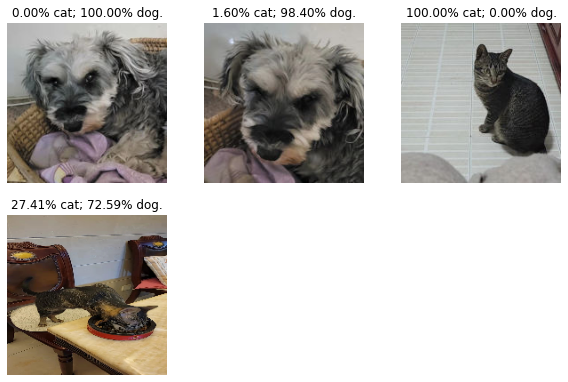

In [12]:
my_pets = 'my-pets'
plt.figure(figsize=(10, 10))
count = 0
for p in os.listdir(my_pets):
    img = keras.preprocessing.image.load_img(
        os.path.join(my_pets, p), target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]
    count += 1
    ax = plt.subplot(3, 3, count)
    plt.imshow(img)
    plt.title(f"{float(100 * (1 - score)):.2f}% cat; {float(100 * score):.2f}% dog.")
    plt.axis("off")

In [15]:
y_pred = []
y_true = []
for x, y in val_ds:
    y_pred.extend(model.predict(x))
    y_true.extend(y.numpy())
y_pred_cat = np.rint([item for sublist in y_pred for item in sublist])

Confusion matrix:
[[2248   73]
 [  76 2285]]


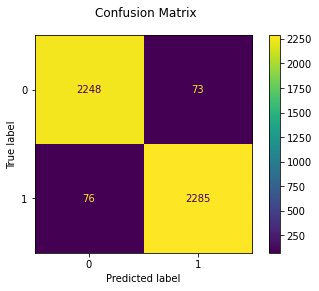

In [16]:
from sklearn import metrics

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred_cat)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [18]:
model.save('01_cnn.model')
# CanNOT save the model easily...Let's skip it...

KeyError: "Failed to add concrete function 'b'__inference_model_layer_call_fn_308085'' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<Resource Tensor>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."